In [43]:
%load_ext autoreload
%autoreload 2
# from ipython import autoreload
import numpy as np
import itertools
import yaml
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import causallearn
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.FCI import fci
import random

from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.experiments.Evaluator import Evaluator
from clustercausal.experiments.ExperimentRunner import ExperimentRunner
from clustercausal.utils.Utils import *
from clustercausal.experiments.Utils import load_experiment_folder
from clustercausal.utils.Utils import *
from clustercausal.experiments.Simulator import Simulator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# # cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
# #                          cluster_edges = [('C1', 'C2'), ('C2', 'C3')], \
# #                          cluster_bidirected_edges=[('C2', 'C3')])
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6'], 'C4' : ['X7', 'X8']}, \
#                          cluster_edges = [('C1', 'C2'), ('C2', 'C3'), ('C1', 'C4')], \
#                          cluster_bidirected_edges=[('C2', 'C3'), ('C3', 'C4')])
# # cluster_dag.cluster_graph.draw_pydot_graph()

In [45]:
simulation = Simulator(n_nodes = 20, n_edges = 20, n_clusters = 4, seed = 232)
cluster_dag = simulation.run_with_latents()

INFO: Finished synthetic dataset


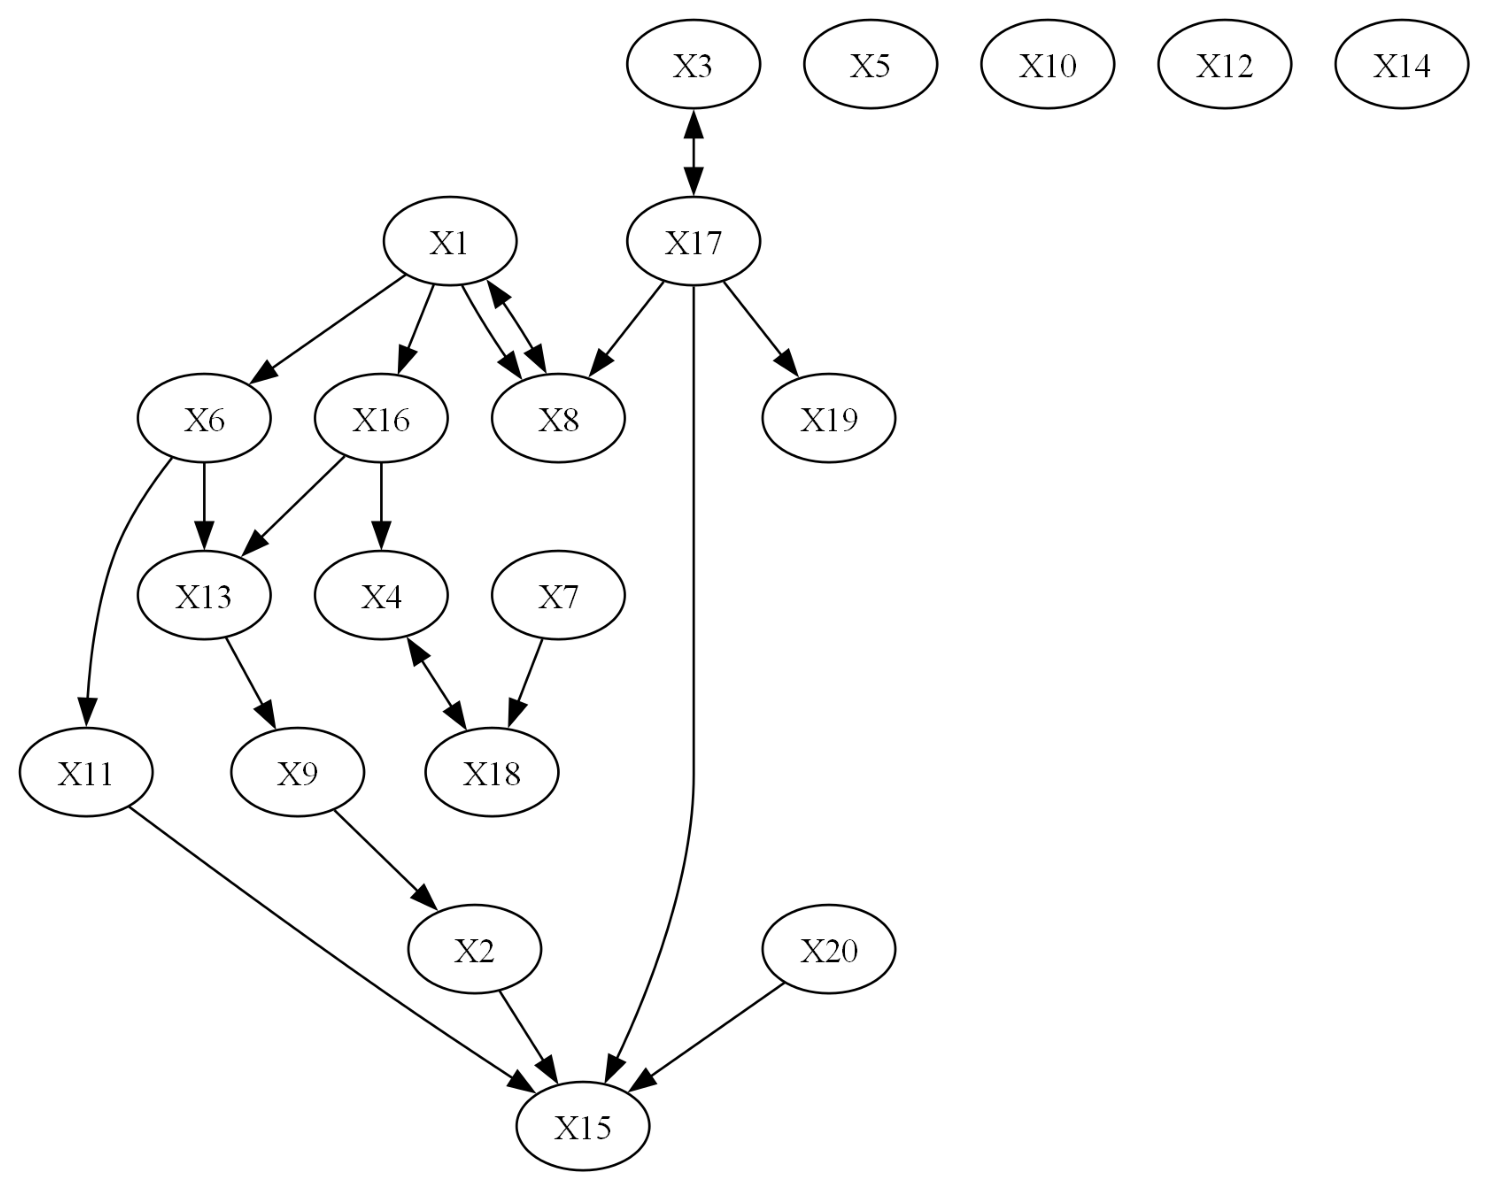

In [46]:
cluster_dag.true_dag.draw_pydot_graph()

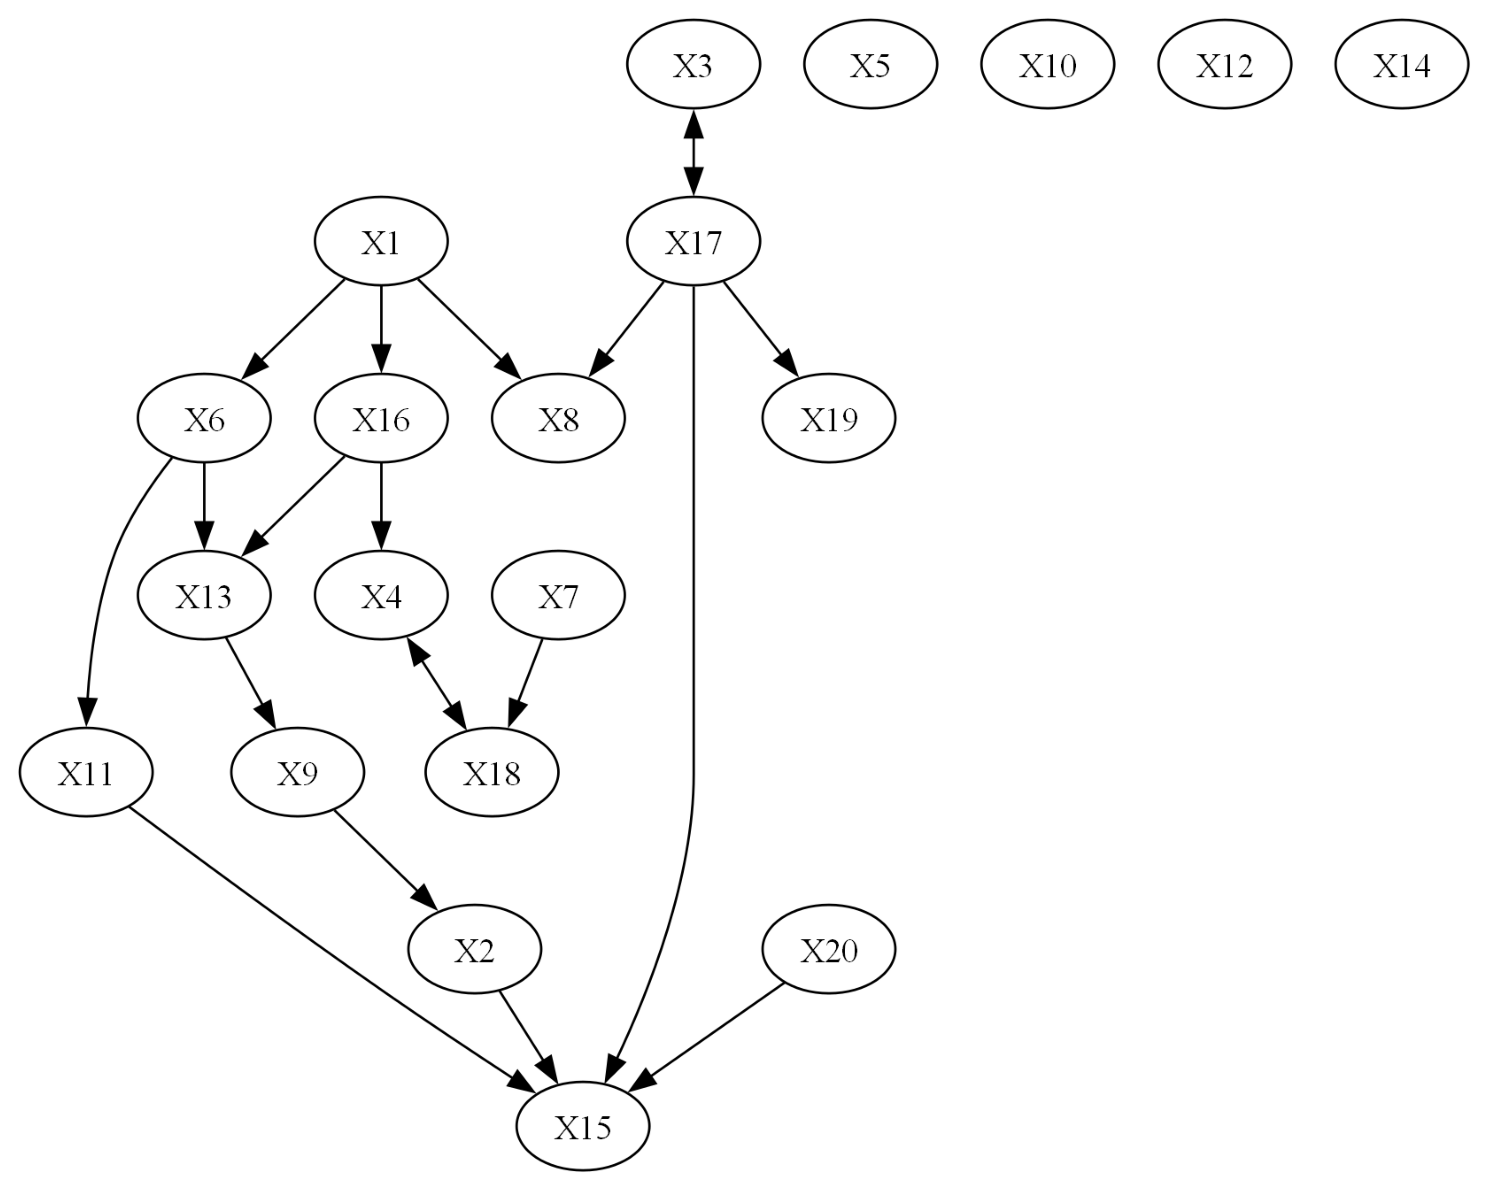

In [47]:
cluster_dag.true_mag.draw_pydot_graph()

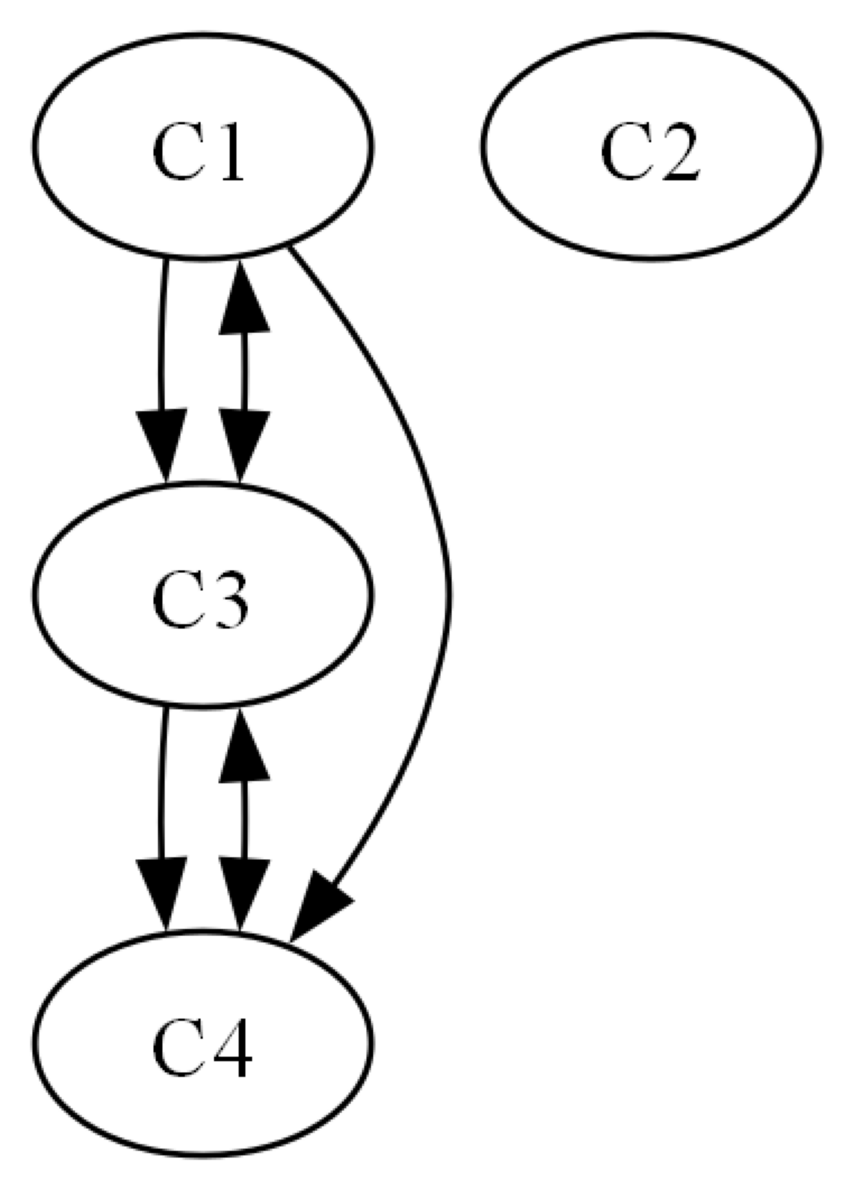

In [48]:
cluster_dag.cluster_graph.draw_pydot_graph()

In [49]:
# cluster_dag.cdag_to_circle_mpdag()
# cluster_dag.cg.draw_pydot_graph()

### Evaluate

In [50]:
cluster_fci = ClusterFCI(cluster_dag, dataset = cluster_dag.data, alpha = 0.05)
cluster_cg, cluster_edges = cluster_fci.run()

Found inducing path between C1 and C4: ['C1', 'C3', 'C4']
Found inducing path between C4 and C1: ['C4', 'C3', 'C1']


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

X2 --> X9
X11 --> X2
X14 --> X2
X15 --> X4
X11 --> X14
X15 --> X13


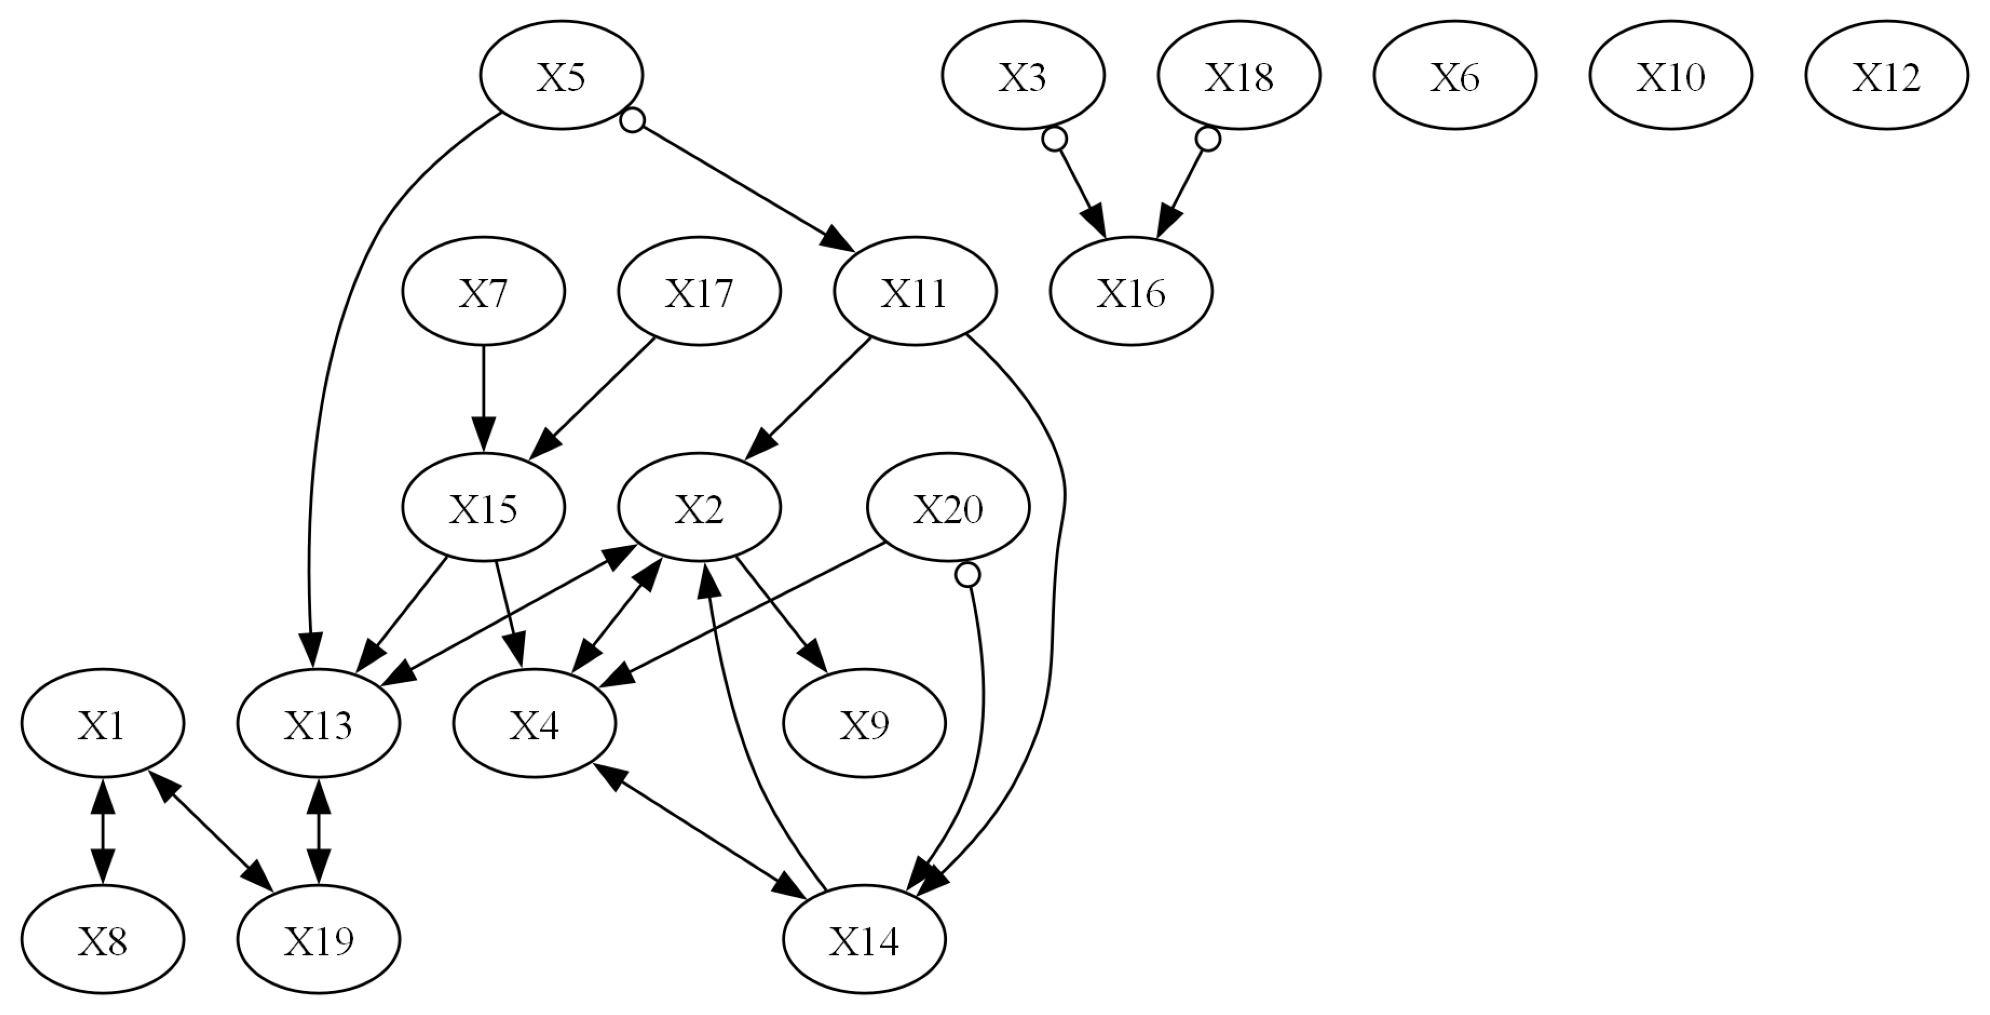

In [51]:
cluster_cg.draw_pydot_graph()

In [52]:
base_G, base_edges = fci(dataset = cluster_dag.data, alpha = 0.05, verbose = False)
base_cg = CausalGraph(len(base_G.get_node_names()))
base_cg.G = base_G

  0%|          | 0/20 [00:00<?, ?it/s]

X2 --> X9
X14 --> X20


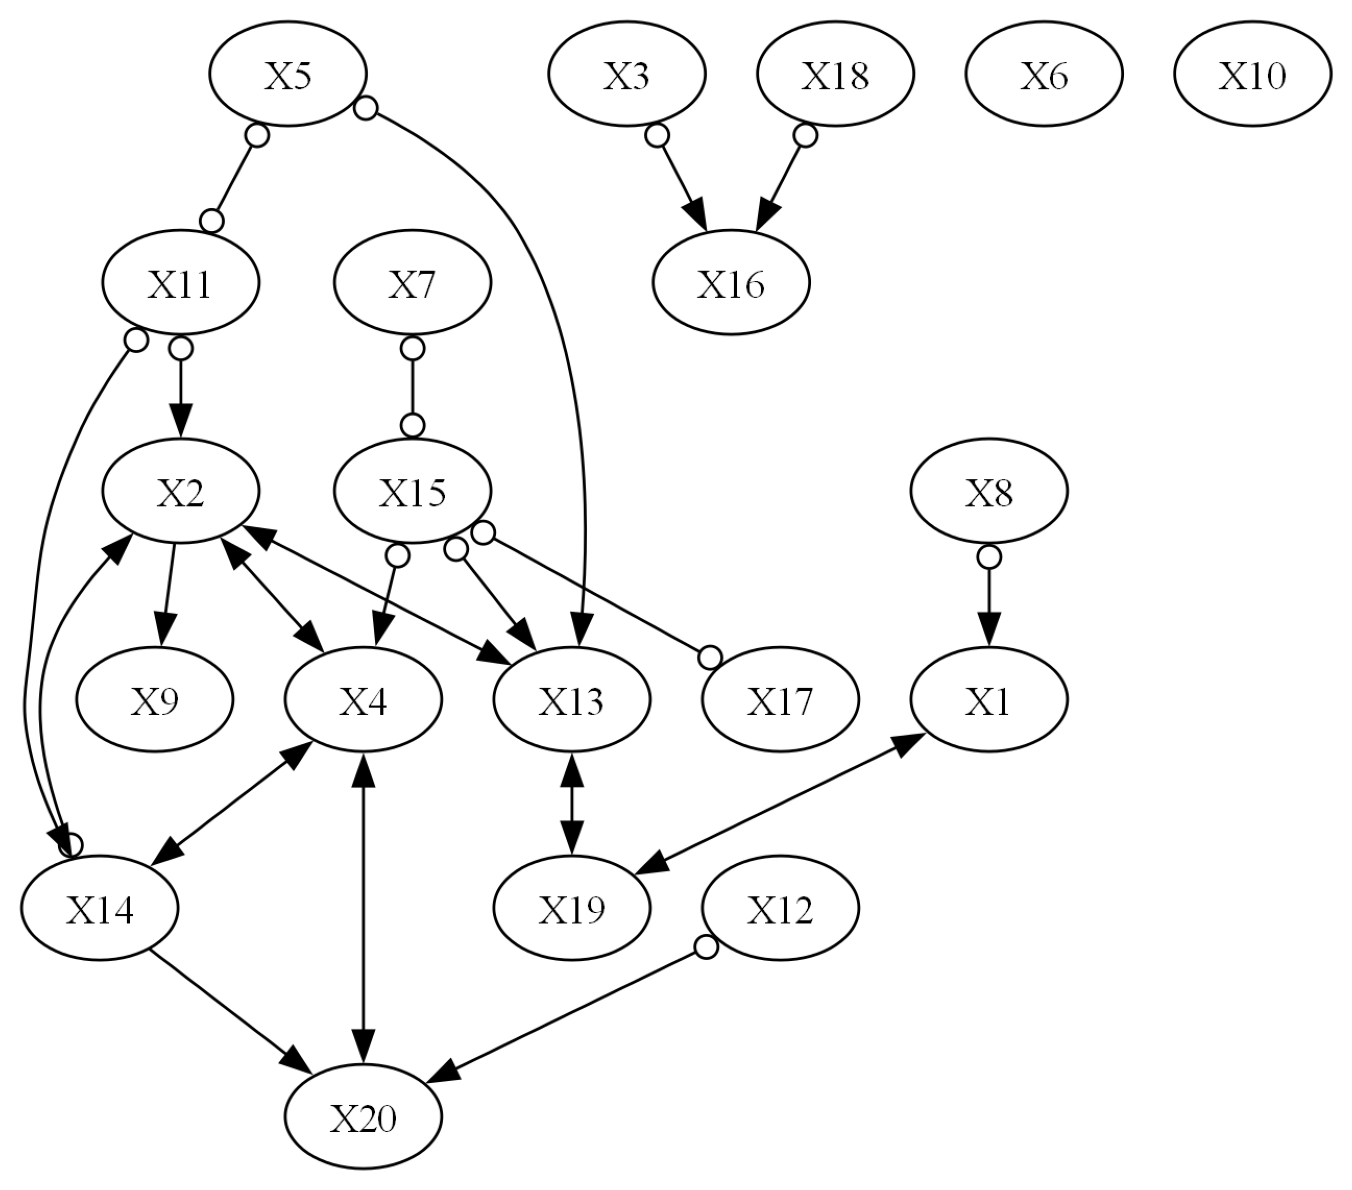

In [53]:
base_cg.draw_pydot_graph()

In [54]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci = Evaluator(truth = cluster_dag.true_mag.G, est = base_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 3, 'false_positive': 18, 'false_negative': 15, 'true_negative': 154, 'precision': 0.14285714285714285, 'recall': 0.16666666666666666, 'f1_score': 0.15384615384615383}
Arrow confusion:  {'true_positive': 0.0, 'false_positive': 24.0, 'false_negative': 20.0, 'true_negative': 356.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': nan, 'true_positive_ce': 0.0, 'false_positive_ce': 2.0, 'false_negative_ce': 3.0, 'true_negative_ce': 395.0, 'precision_ce': 0.0, 'recall_ce': 0.0, 'f1_score_ce': nan}
SHD:  35
SID:  {'sid_lower': None}


invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [55]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = cluster_dag.true_mag.G, est = cluster_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 3, 'false_positive': 17, 'false_negative': 15, 'true_negative': 155, 'precision': 0.15, 'recall': 0.16666666666666666, 'f1_score': 0.15789473684210525}
Arrow confusion:  {'true_positive': 2.0, 'false_positive': 24.0, 'false_negative': 18.0, 'true_negative': 356.0, 'precision': 0.07692307692307693, 'recall': 0.1, 'f1_score': 0.08695652173913043, 'true_positive_ce': 2.0, 'false_positive_ce': 2.0, 'false_negative_ce': 1.0, 'true_negative_ce': 395.0, 'precision_ce': 0.5, 'recall_ce': 0.6666666666666666, 'f1_score_ce': 0.5714285714285715}
SHD:  34
SID:  {'sid_lower': None}


### Run gridsearch

In [ ]:
config_path = 'clustercausal\experiments\configs\cluster_fci_simulation.yaml'
config_path = config_path.replace('\\', '/')
experiment = ExperimentRunner(config_path)
experiment.run_gridsearch_experiment()

INFO: Finished synthetic dataset


Number of experiments: 100


invalid value encountered in divide


X18 --> X2
X5 --> X9


  0%|          | 0/20 [00:00<?, ?it/s]

X13 --> X6


INFO: Finished synthetic dataset


X13 --> X6
X17 --> X14


  0%|          | 0/20 [00:00<?, ?it/s]

X5 --> X20
X5 --> X20


INFO: Finished synthetic dataset


X12 --> X2
X2 --> X14
X14 --> X18
X18 --> X19


  0%|          | 0/20 [00:00<?, ?it/s]

X6 --> X4


INFO: Finished synthetic dataset


X6 --> X4
X10 --> X18
X11 --> X14
X14 --> X12


  0%|          | 0/20 [00:00<?, ?it/s]

invalid value encountered in double_scalars
INFO: Finished synthetic dataset


In [76]:
data = load_experiment_folder('clustercausal\experiments\_results')

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [77]:
# data_all also contains runs with n_clusters = 1
data_all = data.copy()
data = data[data['n_clusters'] != 1]
# To look only at clusterings where at least two clusters were non-adjacent
data_nonadj_clusters = data[data['cluster_connectivity'] != 1]

In [78]:
data_all.describe()

,base_adj_f1_score,base_adj_false_negative,base_adj_false_positive,base_adj_precision,base_adj_recall,base_adj_true_negative,base_adj_true_positive,base_arrow_f1_score,base_arrow_f1_score_ce,base_arrow_false_negative,...,alpha,cluster_connectivity,empty_graph_shd,n_clusters,n_edges,n_nodes,noise_scale,sample_size,true_sid_lower,true_sid_upper
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,21.000000,22.000000,...,2.200000e+01,22.000000,22.000000,22.0,22.0,22.0,22.0,22.0,0.0,0.0
mean,0.175234,19.954545,11.318182,0.236449,0.142063,155.272727,3.454545,0.106902,0.576505,29.227273,...,5.000000e-02,0.527273,23.409091,5.0,24.0,24.0,1.0,1000.0,NaN,NaN
std,0.153759,4.202916,4.156307,0.220812,0.121348,6.901910,3.217915,0.105528,0.277442,8.017432,...,1.420437e-17,0.183048,4.646136,0.0,0.0,0.0,0.0,0.0,NaN,NaN
min,0.000000,10.000000,0.000000,0.000000,0.000000,143.000000,0.000000,0.000000,0.000000,16.000000,...,5.000000e-02,0.200000,18.000000,5.0,24.0,24.0,1.0,1000.0,NaN,NaN
25%,0.086224,17.000000,9.250000,0.119485,0.068519,151.250000,2.000000,0.042195,0.400000,23.250000,...,5.000000e-02,0.425000,19.250000,5.0,24.0,24.0,1.0,1000.0,NaN,NaN
50%,0.127891,20.000000,11.500000,0.162281,0.107280,155.000000,2.000000,0.078462,0.571429,28.000000,...,5.000000e-02,0.500000,22.500000,5.0,24.0,24.0,1.0,1000.0,NaN,NaN
75%,0.182292,22.000000,14.000000,0.250000,0.145833,160.250000,3.750000,0.117225,0.800000,35.500000,...,5.000000e-02,0.675000,26.750000,5.0,24.0,24.0,1.0,1000.0,NaN,NaN
max,0.642857,28.000000,17.000000,1.000000,0.473684,171.000000,13.000000,0.424242,1.000000,45.000000,...,5.000000e-02,0.800000,32.000000,5.0,24.0,24.0,1.0,1000.0,NaN,NaN


In [79]:
prec_recall_metrics_with_pruned = ['base_adj_precision', 'pruned_base_adj_precision', 'cluster_adj_precision', \
           'base_adj_recall', 'pruned_base_adj_recall','cluster_adj_recall', \
           'base_adj_f1_score', 'pruned_base_adj_f1_score', 'cluster_adj_f1_score']
prec_recall_metrics = ['base_adj_precision', 'cluster_adj_precision', \
              'base_adj_recall', 'cluster_adj_recall', \
                'base_adj_f1_score', 'cluster_adj_f1_score']
data_all[prec_recall_metrics].describe()

,base_adj_precision,cluster_adj_precision,base_adj_recall,cluster_adj_recall,base_adj_f1_score,cluster_adj_f1_score
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.236449,0.227270,0.142063,0.174185,0.175234,0.195853
std,0.220812,0.199950,0.121348,0.137304,0.153759,0.161873
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.119485,0.119485,0.068519,0.087945,0.086224,0.103571
50%,0.162281,0.158333,0.107280,0.133333,0.127891,0.143346
75%,0.250000,0.257368,0.145833,0.214744,0.182292,0.228632
max,1.000000,0.846154,0.473684,0.578947,0.642857,0.687500
